In [1]:
# !poetry run pip install -U git+https://github.com/ichko/aesthetic-tensor

In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from kornia import augmentation

from tqdm.auto import tqdm
import base64
import matplotlib
from io import BytesIO
from PIL import Image
from IPython.display import HTML
import mediapy as mpy
import os

In [3]:
from aesthetic_tensor import monkey_patch_torch
monkey_patch_torch()

In [4]:
from nca.utils import conv_same

In [5]:
class SimpleNCA(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        perc = 3
        hid = 128
        self.chans = 16

        self.seed = nn.Parameter(torch.rand(self.chans, 64, 64) * 2 - 1)
        self.kernel = nn.Sequential(
            nn.Dropout2d(p=0.1),
            conv_same(self.chans, perc * self.chans, ks=5, bias=True, padding_mode="circular"),
            nn.BatchNorm2d(perc * self.chans),
        )
        
        sobel_x = torch.tensor([[-1.0,0.0,1.0],[-2.0,0.0,2.0],[-1.0,0.0,1.0]])/8
        sobel_y = torch.tensor([[1.0,2.0,1.0],[0.0,0.0,0.0],[-1.0,-2.0,-1.0]])/8
        identity = torch.tensor([[0.0,0.0,0.0],[0.0,1.0,0.0],[0.0,0.0,0.0]])
#         lap = torch.tensor([[1.0,2.0,1.0],[2.0,-12,2.0],[1.0,2.0,1.0]])

        all_filters = torch.stack((identity, sobel_x, sobel_y))
        all_filters_batch = all_filters.repeat(self.chans, 1, 1).unsqueeze(1)
        self.all_filters_batch = nn.Parameter(all_filters_batch, requires_grad=False)
        
        self.rule = nn.Sequential(
            conv_same(perc * self.chans, hid, ks=1, bias=True),
            nn.ReLU(),
            conv_same(hid, self.chans, ks=1, bias=False),
        )

#         for p in self.kernel.parameters():
#             nn.init.normal_(p)
#         for p in list(self.rule.parameters()):
#             nn.init.normal_(p)
#         nn.init.zeros_(self.rule[-1].bias)
        nn.init.zeros_(self.rule[-1].weight)

    def forward(self, x, steps=1):
        seq = [x]
        device = next(self.parameters()).device
        for i in range(steps):
            old_x = x
#             x *= 1 + (torch.rand_like(x) - 0.5) / 25
#             x = x + (torch.rand_like(x) - 0.5) / 10
#             x = self.kernel(x)
#             x = x + self.seed
            x = F.conv2d(
                F.pad(x, (1, 1, 1, 1), "circular"),
#                 F.pad(x, (1, 1, 1, 1), "constant", 0),
                self.all_filters_batch,
                stride=1,
                padding=0,
                groups=self.chans,
            )
            x = self.rule(x)
            x = old_x + x
            seq.append(x)

        seq = torch.stack(seq, axis=1)
        return seq

In [6]:
def fast_hist(inp):
    s = 50
    S = 50
    vals = (inp*s).to(torch.int32).view(-1)
    hist = torch.bincount(vals)
    hist_screen = torch.zeros((S, s * 2))
    sizes = (hist / (hist.sum() / 8) * S).to(torch.int32)
    print(sizes)
    for i, s_val in enumerate(sizes):
        if s_val > 0:
            print(s_val, s - 1)
            hist_screen[-min(s_val, s - 1):, 2 * i] = 1

    return hist_screen

In [7]:
import torchsummary

In [8]:
nca = SimpleNCA()

In [50]:
torch.tensor([1,2,3]).repeat(2)

tensor([1, 2, 3, 1, 2, 3])

In [9]:
S = 64
inp1 = torch.rand(2, nca.chans, S, S) * 2 - 1
inp2 = torch.zeros(1, nca.chans, S, S)
inp2[0, 0, 32, 32] = 1

inp3 = torch.ones(1, nca.chans, S, S)
inp3[0, 0, 32, 32] = 0

inp = torch.cat([inp1, inp2, inp3])

out = nca(inp, steps=50)
out.ae

float32<4, 51, 16, 64, 64>∈[-1.000, 1.000] | μ=0.250, σ=0.595

In [10]:
torchsummary.summary(nca.to("cuda"), input_size=inp1.size()[1:])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 64, 64]           6,272
              ReLU-2          [-1, 128, 64, 64]               0
            Conv2d-3           [-1, 16, 64, 64]           2,048
Total params: 8,320
Trainable params: 8,320
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.25
Forward/backward pass size (MB): 8.50
Params size (MB): 0.03
Estimated Total Size (MB): 8.78
----------------------------------------------------------------



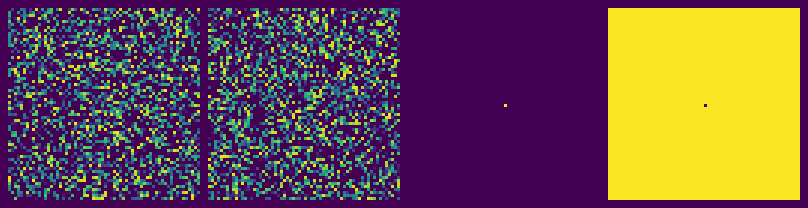

In [11]:
out.ae.zoom(3).grid(ncols=4, pad=4)[:, 0].gif(fps=24)

In [12]:
out.ae

float32<4, 51, 16, 64, 64>∈[-1.000, 1.000] | μ=0.250, σ=0.595

In [13]:
# hist_anim = torch.stack([fast_hist(out[3, i]) for i in range(200)])
# hist_anim.ae.zoom(2).cmap("binary").gif(fps=24)

In [14]:
single = out[1,:,0]
vals = single.reshape(single.shape[0], -1).sum(axis=1)
vals = vals.detach().cpu().numpy()
# plt.plot(vals)

In [15]:
from torchvision.datasets.mnist import MNIST
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
from torchdata.datapipes.iter import IterableWrapper

In [16]:
num_classes = 10

In [17]:
import cv2

S = 64
screen = np.zeros((S, S))

for i, tau in enumerate(np.linspace(0, np.pi * 2, num_classes, endpoint=False)):
    sr = 10
    r = 25

    x1 = S // 2 + int(np.cos(tau) * sr)
    y1 = S // 2 + int(np.sin(tau) * sr)
    x2 = S // 2 + int(np.cos(tau) * r)
    y2 = S // 2 + int(np.sin(tau) * r)
    cv2.line(screen, [x1, y1], [x2, y2], color=1, thickness=2)

explode_screen = torch.tensor(screen, dtype=torch.float32)
explode_screen.ae.imshow(figsize=(3, 3))

In [18]:
import cv2

S = 64
screen = np.zeros((S, S))

for i, tau in enumerate(np.linspace(0, np.pi * 2, num_classes, endpoint=False)):
    sr = 8
    r = 27
    x = S // 2 + int(np.cos(tau) * r)
    y = S // 2 + int(np.sin(tau) * r)
    cv2.circle(screen, [x,  y], sr, i + 1, thickness=-1)
    
    
    x1 = S // 2 + int(np.cos(tau) * sr)
    y1 = S // 2 + int(np.sin(tau) * sr)
    x2 = S // 2 + int(np.cos(tau) * r)
    y2 = S // 2 + int(np.sin(tau) * r)
#     cv2.line(screen, [x1, y1], [x2, y2], color=i + 1, thickness=2)

#     cv2.circle(screen, [x,  y], sr * 3 - i * 3, i + 1, thickness=-1)
#     cv2.polylines(screen, [[x, y], [x]])

screen = torch.tensor(screen)
screen.ae.imshow(figsize=(3, 3))

In [19]:
ds = MNIST(root="./.data", download=True, transform=ToTensor(), train=True)

In [20]:
bs = 32
dl = DataLoader(IterableWrapper(ds).filter(lambda x: x[1] < num_classes), batch_size=bs, shuffle=True)

/home/iz/.cache/pypoetry/virtualenvs/nca-ar8j7Liq-py3.10/lib/python3.10/site-packages/torch/utils/data/datapipes/utils/common.py:145: UserWarning: Lambda function is not supported by pickle, please use regular python function or functools.partial instead.
  warnings.warn(
/home/iz/.cache/pypoetry/virtualenvs/nca-ar8j7Liq-py3.10/lib/python3.10/site-packages/torch/utils/data/graph_settings.py:90: UserWarning: `shuffle=True` was set, but the datapipe does not contain a `Shuffler`. Adding one at the end. Be aware that the default buffer size might not be sufficient for your task.
  warnings.warn(


In [21]:
batch = next(iter(dl))

In [22]:
def sample_random_input(dl):
    it = iter(dl)
    while True:
        try:
            x, y = next(it)
#             x = x * 2 - 1
        except StopIteration:
            it = iter(dl)
        bs, _, H, W = x.shape
        ws = 64
        s = x.shape[-1]
        digit_screen = torch.zeros(bs, nca.chans, ws, ws)
        f = ws//2 - s//2
        digit_screen[:, :3, f:f+s, f:f+s] = x
        t = (screen.unsqueeze(0) == y.unsqueeze(1).unsqueeze(1) + 1).to(torch.float32)
        yield digit_screen, y, t

In [23]:
gen = sample_random_input(dl)
batch = next(gen)
x, y, t = batch
x[:16].ae.zoom(2).grid()[0].img

In [24]:
(t[:16]).ae.zoom(2).grid().img

In [25]:
batch[0].ae

float32<32, 16, 64, 64>∈[0.000, 1.000] | μ=0.004, σ=0.062

In [26]:
out = nca.to("cpu")(batch[0], steps=40)

In [27]:
# out[:16].ae.zoom(2).grid(ncols=8, pad=2)[:, 0].gif(fps=10)

In [28]:
torch.stack(
    [torch.tensor(screen == i) for i in range(num_classes + 1)]
).to(float).ae.zoom(3).grid(ncols=num_classes + 1).img

/tmp/ipykernel_3931343/547381105.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [torch.tensor(screen == i) for i in range(num_classes + 1)]


In [29]:
def optim_step(i, nca, batch, optim, device, grad_clip_val=0.1):
    x, y, t = batch
    x = x.to(device)
    y = y.to(device)
    t = t.to(device)
    out = nca(x, steps=np.random.randint(60, 80))
    last = np.random.randint(1, 5)

    clf_out = torch.stack([
        out[:, -1:, 0].mean(axis=1)[:, screen == s + 1].mean(axis=1)
        for s in range(len(np.unique(screen)) - 1)
    ], axis=1)

    target_out = out[:, -last:, 0].abs().mean(axis=[1])
    target_out_mid = out[:, 32:34, 0].abs().mean(axis=[1])

    loss = F.mse_loss(target_out, t)
    loss += F.mse_loss(target_out_mid, explode_screen.to(device))

    optim.zero_grad()
    loss.backward()
#     torch.nn.utils.clip_grad_norm_(nca.parameters(), grad_clip_val)
    optim.step()
    
    return loss, out

In [30]:
from copy import deepcopy

In [31]:
lr = 0.0008
target_nca = deepcopy(nca)
history = []

In [32]:
with open("save-exploding.pkl", "rb") as fp:
    target_nca = torch.load(fp)

In [33]:
optim = torch.optim.Adam(target_nca.parameters(), lr=lr)

In [34]:
device = "cuda"
target_nca = target_nca.to(device)

In [35]:
# _ = optim_step(i, target_nca, batch, optim, device)

In [36]:
torch.autograd.set_detect_anomaly(True)

In [37]:
# target_nca.kernel[0].padding_mode = "circular"

In [38]:
# !rm -rf checkpoints/

In [39]:
save_dir = "checkpoints"
os.makedirs(save_dir, exist_ok=True)

In [40]:
# !du -h checkpoints/*

In [41]:
# from IPython.display import clear_output
# pbar = tqdm(range(50000))

# for i in pbar:
#     batch = next(gen)
#     loss, out = optim_step(i, target_nca, batch, optim, device)
#     pbar.set_description(f"Loss: {loss:.10f}")
#     history.append(loss.item())

#     if i % 250 == 0:
#         clear_output(wait=True)
#         display(pbar.container)
#         plt.plot(history)
#         plt.yscale("log")
#         plt.show()

#         with torch.no_grad():
#             gif = out[:16].ae.zoom(2).grid(ncols=8, pad=2)[:, 0].gif(fps=24)
#             display(gif)
            
#             with open(os.path.join(save_dir, f"model-{i:05}-Lf{loss.item():0.6f}.pkl"), "wb+") as fp:
#                 torch.save(target_nca, fp)

In [42]:
loss, out = optim_step(i, target_nca, batch, optim, device)

/tmp/ipykernel_3931343/4157092789.py:18: UserWarning: Using a target size (torch.Size([64, 64])) that is different to the input size (torch.Size([32, 64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss += F.mse_loss(target_out_mid, explode_screen.to(device))


In [46]:
out[:16].ae

float32<16, 67, 16, 64, 64>∈[-49.900, 56.308] | μ=0.049, σ=1.778

In [43]:
gif = out[:16].ae.zoom(2).grid(ncols=8, pad=2)[:, 0].gif(fps=24)


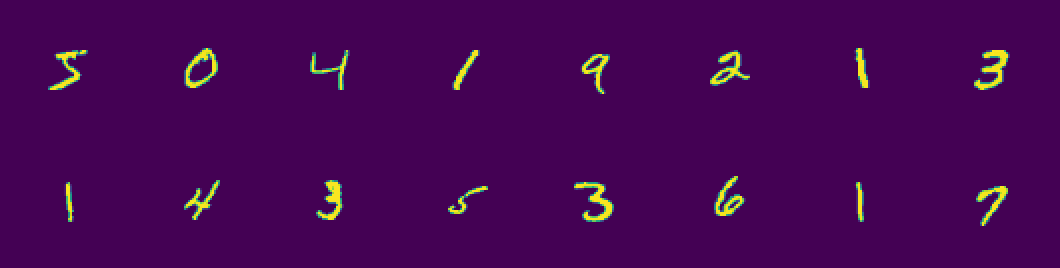

In [44]:
gif

In [108]:
torch.cuda.empty_cache()

In [41]:
with open("save-exploding-color.pkl", "wb+") as fp:
    torch.save(target_nca, fp)

In [43]:
cls_outs = {}
with torch.inference_mode():
    for i in tqdm(range(10)):
        batch = next(gen)
        x, y, t = batch
        out = target_nca.eval().to("cpu")(x.to("cpu"), steps=110)
        for cls in range(num_classes):
            cls_mask = y.to("cpu") == cls
            cls_out = out[cls_mask]
            cls_outs.setdefault(cls, []).append([cls_out, t[cls_mask]])

  0%|          | 0/10 [00:00<?, ?it/s]

In [44]:
num_outs = []
for cls in range(num_classes):
    max_val = -1
    max_id = -1
    max_out = None
    for outs, t in cls_outs[cls]:
        if outs.shape[0] == 0:
            continue
        vals = -((outs[:, -1, 0] - t) ** 2).mean([1, 2])
        argmax = vals.argmax()
        if vals[argmax] > max_val:
            max_val = vals[argmax]
            max_id = argmax
            max_out = outs[argmax]

    num_outs.append(max_out)

num_outs = torch.stack(num_outs)
num_outs.ae

float32<10, 111, 16, 64, 64>∈[-52.421, 65.404] | μ=0.040, σ=1.560

In [45]:
# from aesthetic_tensor import ae

# os = 32
# s = 4
# ss = os * s
# ae(
#     cv2.putText(
#         num_outs[2, -1, 0].ae.zoom(4).raw.copy(),
#         text="1", org=(ss // 2, ss // 2),
#         fontFace=2, fontScale=1, color=(255,255,255), thickness=-1, lineType=-1
#     )
# ).zoom(1).img

In [46]:
torch.cat([
    num_outs[:, :1].repeat((1, 20, 1, 1, 1)),
    num_outs,
], dim=1).ae.zoom(3).grid(ncols=10, pad=2)[:, 0]

float32<131, 200, 1964>∈[-1.030, 2.469] | μ=0.047, σ=0.162

In [47]:
vid = torch.cat([
    num_outs[:, :1].repeat((1, 20, 1, 1, 1)),
    num_outs,
], dim=1).ae.zoom(5).grid(ncols=3, pad=2)

In [ ]:
vid

In [ ]:
# mpy.show_video(vid.raw, fps=60, border=True)

In [ ]:
paused = torch.cat([
    num_outs[:, :1].repeat((1, 40, 1, 1, 1)),
    num_outs,
    num_outs[:, -1:].repeat((1, 20, 1, 1, 1)),
], dim=1)

In [ ]:
paused.ae

In [ ]:
hid_vid = paused.permute(0, 2, 1, 3, 4)[:,[0,1,3,8,9,10,11,12,13,14]].ae \
    .grid(ncols=1).grid(ncols=10).zoom(1).cmap("viridis")[:, :, :, :3]

In [ ]:
hid_vid

In [ ]:
mpy.show_video(hid_vid.raw, fps=60, border=True)

In [ ]:
colors = [
    'tab:blue',
    'tab:orange',
    'tab:green',
    'tab:red',
    'tab:purple',
    'tab:brown',
    'tab:pink',
    'tab:gray',
    'tab:olive',
    'tab:cyan',
]

In [ ]:
def plot_fun(out, frame_id=-1, batch_id=0):
    f = frame_id
    b = batch_id
    out = out.detach().cpu()
    bs, L, _, H, W = out.shape
    im = out[b, f, 0]

    vals_list = []
    for cls in range(num_classes):
        vals = out[b, :f, 0][:, screen == cls + 1].mean(axis=-1)
        vals_list.append(vals)

    bar_vals_list = []
    for cls in range(num_classes):
        bar_vals = out[b, f, 0][screen == cls + 1].mean(axis=-1)
        bar_vals_list.append(bar_vals)
    bar_vals = torch.stack(bar_vals_list)

    fig, axs = plt.subplots(3, 1, figsize=(2, 6), dpi=100)
    axs[0].imshow(out[b, frame_id, 0], interpolation='none', aspect="auto")

    axs[0].set_xticks([])
    axs[1].set_xticks([])
    axs[2].set_xticks([])
    axs[0].set_yticks([])
    axs[1].set_yticks([])
    axs[2].set_yticks([])

    for cls in range(num_classes):
        c = colors[cls]
#         axs[1].contour(screen == cls + 1, colors=c, linewidths=3, alpha=0.6)
        axs[1].plot(vals_list[cls], c=c)
        axs[2].bar(range(num_classes), bar_vals, color=colors[:num_classes])

#     axs[0].set_aspect(1)
    axs[1].axhline(1, color="tab:grey", linestyle="--", linewidth=0.5)
    axs[1].axhline(0, color="tab:grey", linestyle="--", linewidth=0.5)
    axs[1].set_xlim(0, L)
    axs[1].set_ylim(-0.1, 1.1)

    axs[2].set_ylim(0, 1)
    axs[2].set_xticks(range(num_classes))

    plt.tight_layout(pad=1)

    plt.close()
    return fig

plot_fun(paused, -1, 0)

In [ ]:
L = paused.shape[1]
figs_list = []
for cls in tqdm(range(num_classes)):
    figs = [plot_fun(paused, i, cls) for i in tqdm(range(0, L))]
    figs_list.append(figs)

In [ ]:
def fig2img(fig):
    """Convert a Matplotlib figure to a PIL Image and return it"""
    import io
    buf = io.BytesIO()
    fig.savefig(buf, bbox_inches="tight", pad_inches=0.1)
    buf.seek(0)
    img = Image.open(buf)
    return img

In [ ]:
pils_list = []
for figs in tqdm(figs_list):
    pils = [fig2img(f) for f in tqdm(figs)]
    pils_list.append(pils)

In [ ]:
# pils_list[0][-1]

In [ ]:
cat_pils = [
    Image.fromarray(
        np.concatenate([
            np.concatenate([np.array(ps[frame_id]) for ps in pils_list[:10]  ], axis=1),
#             np.concatenate([np.array(ps[frame_id]) for ps in pils_list[5:10]], axis=1)
        ], axis=0)
    ) for frame_id in tqdm(range(len(pils_list[0])))
]

In [ ]:
import numpy as np

image_stack = np.ones((2, 2, 18))

extra_left, extra_right = 1, 2
extra_top, extra_bottom = 3, 1

np.pad(image_stack, ((extra_top, extra_bottom), (extra_left, extra_right), (0, 0)),
       mode='constant', constant_values=3).shape

In [ ]:
def rescale_pil(pil, scale=1):
    W, H = pil.size
    new_W, new_H = int(W * scale), int(H * scale)
    return pil.resize((new_W, new_H))

In [ ]:
rescale_pil(cat_pils[0], scale=0.9).size

In [ ]:
def gif_from_pils(pils, fps):
    pils = [rescale_pil(p, scale=0.9) for p in pils]
    fp = BytesIO()
    pils[0].save(
        fp,
        format="gif",
        save_all=True,
        append_images=pils[1:],
        duration=1000 / fps,
        loop=0,
    )
    fp.seek(0)
    
    b64 = base64.b64encode(fp.read()).decode("ascii")
    html = f"""<img src="data:image/gif;base64,{b64}" />"""
    return HTML(html)

In [ ]:
len(cat_pils)

In [ ]:
gif_from_pils(cat_pils[10:], fps=30)

In [ ]:
from flask import Flask, render_template, Response, request
import multiprocessing
import cv2
import numpy as np

In [ ]:
app = Flask(__name__)

In [ ]:
def gen_frames():  
    while True:
        frame = np.random.randint(0, 255, size=(100, 100, 3), dtype=np.uint8)
        ret, buffer = cv2.imencode('.jpg', frame)
        frame = buffer.tobytes()
        yield (b'--frame\r\n'
               b'Content-Type: image/jpeg\r\n\r\n' + frame + b'\r\n')  # concat

In [ ]:
@app.route('/video_feed')
def video_feed():
    return Response(gen_frames(), mimetype='multipart/x-mixed-replace; boundary=frame')

In [ ]:
def shutdown_server():
    func = request.environ.get('werkzeug.server.shutdown')
    if func is None:
        raise RuntimeError('Not running with the Werkzeug Server')
    func()
    
@app.get('/shutdown')
def shutdown():
    shutdown_server()
    return 'Server shutting down...'

In [ ]:
def run():
    app.run(debug=False, port=8789)

In [ ]:
import threading
# t = threading.Thread(target=run)
t = multiprocessing.Process(target=run)

In [ ]:
t.start()

In [ ]:
t.terminate()

In [ ]:
%%html
<img src="http://localhost:8789/video_feed"/>

In [ ]:
%%javascript

